_Lambda School Data Science Unit 2_
 
 # Sprint Challenge: Practicing & Understanding Predictive Modeling

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [2]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import random
from matplotlib.pyplot import cm
import numpy as np
from ipywidgets import interact
from sklearn.exceptions import DataConversionWarning
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
import category_encoders as ce
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

In [47]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

In [48]:
train['Fail'].mean()#Baseline

0.25861006240850604

In [63]:
train = train.head(1000)
test = test.head(1000)

In [64]:
train.head(1)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1


In [69]:
features = ['Facility Type',
 'Risk',
 'Address',
 'City',
 'State',
 'Zip',
 'Inspection Date',
 'Inspection Type']
target = 'Fail'

preprocessor = make_pipeline(ce.OrdinalEncoder(), SimpleImputer())#sex is assigned integers with ordinal encoder
X = preprocessor.fit_transform(train_d[features])
X = pd.DataFrame(X, columns=features)
y = train_d[target]

X.head()

,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type
0,1.0,1.0,1.0,1.0,1.0,60657.0,1.0,1.0
1,2.0,2.0,2.0,1.0,1.0,60636.0,2.0,2.0
2,1.0,1.0,3.0,1.0,1.0,60649.0,3.0,3.0
3,1.0,3.0,4.0,1.0,1.0,60632.0,4.0,1.0
4,3.0,1.0,5.0,1.0,1.0,60629.0,5.0,1.0


In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [71]:
# Random Forest Regressor - this is a regressor problem
from sklearn. ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, max_depth=None, n_jobs=-1)#Instantiating Random Forest Regressor Object
#this model should pick up non-linear, non-monotonic and interactions between features. 
#With these features this is the best that can be done without feature engineering and hyperparameter tuning

scores = cross_validate(model, X_train, y_train,#doing cross validation with random forest
                        scoring='neg_mean_absolute_error',
                        cv=3, return_train_score=True,
                        return_estimator=True)
pd.DataFrame(scores)
#random forest not performing as well as linear regression

,fit_time,score_time,estimator,test_score,train_score
0,1.901925,0.106120,"(DecisionTreeRegressor(criterion='mse', max_de...",-0.349663,-0.128016
1,1.768309,0.104944,"(DecisionTreeRegressor(criterion='mse', max_de...",-0.346522,-0.128537
2,1.795202,0.104631,"(DecisionTreeRegressor(criterion='mse', max_de...",-0.347901,-0.128475


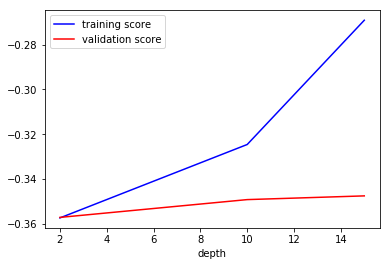

In [72]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

model = RandomForestRegressor(n_estimators=100)

depth = [2, 10, 15]#try a range of values for these parameters
train_score, val_score = validation_curve(
    model, X_train, y_train,
    param_name='max_depth', param_range=depth, 
    scoring='neg_mean_absolute_error', cv=3)

plt.plot(depth, np.median(train_score, 1), color='blue', label='training score')
plt.plot(depth, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.xlabel('depth');

In [74]:
from sklearn.model_selection import train_test_split

def train_validation_test_split(
    X, y, train_size=0.8, val_size=0.1, test_size=0.1, 
    random_state=None, shuffle=True):
        
    assert train_size + val_size + test_size == 1
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=shuffle)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size/(train_size+val_size), 
        random_state=random_state, shuffle=shuffle)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [76]:
from sklearn.metrics import classification_report, confusion_matrix


X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(
    X, y, train_size=0.8, val_size=0.1, test_size=0.1, random_state=1)

class_weight = None

model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

depth = [2, 10, 15]#try a range of values for these parameters
train_score, val_score = validation_curve(
    model, X_train, y_train,
    param_name='max_depth', param_range=depth, 
    scoring='neg_mean_absolute_error', cv=3)


y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))
print('accuracy', accuracy_score(y_val, y_pred))
display(pd.DataFrame(
    confusion_matrix(y_val, y_pred), 
    columns=['Predicted Negative', 'Predicted Positive'], 
    index=['Actual Negative', 'Actual Positive']))


# 5. Visualize decision regions

plt.figure(figsize=(10, 6))
plot_decision_regions(X_val, y_val, model, legend=0)

y_pred_proba = model.predict_proba(X_val)[:,1]
print('ROC AUC', roc_auc_score(y_val, y_pred_proba))

ValueError: Classification metrics can't handle a mix of binary and continuous targets

interactive(children=(IntSlider(value=2, description='max_depth', max=10, min=2), IntSlider(value=10, descript…

<function __main__.titanic_trees(max_depth=1, n_estimators=1)>

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) **Use cross-validation** to **do hyperparameter optimization**, and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:

- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

_To earn a score of 3 for this part, make at least two of these visualization types._

### Part 4: Gradient Descent

Answer both of these two questions:

- What does Gradient Descent seek to minimize?
- What is the "Learning Rate" and what is its function?

One sentence is sufficient for each.

_To earn a score of 3 for this part, go above and beyond. Show depth of understanding and mastery of intuition in your answers._